In [1]:
import numpy as np
import pandas as pd
import spacy
import string
import pickle as pkl
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

## Load Data

In [2]:
train_df = pd.read_csv('data/snli_train.tsv','\t')
val_df = pd.read_csv('data/snli_val.tsv','\t')

In [3]:
mapping = {'neutral': 0, 'entailment': 1, 'contradiction': 2}
train_df = train_df.applymap(lambda s: mapping.get(s) if s in mapping else s)
val_df = val_df.applymap(lambda s: mapping.get(s) if s in mapping else s)

In [4]:
train_target = list(train_df['label'])
val_target = list(val_df['label'])

In [5]:
# tokenizer = spacy.load('en_core_web_sm')
# punctuations = string.punctuation

# # lowercase and remove punctuation
# def tokenize(sent):
#     tokens = tokenizer(sent)
#     return [token.text.lower() for token in tokens if (token.text not in punctuations)]

# # tokenize datasets
# def tokenize_dataset(dataset):
#     token_dataset = []
#     # we are keeping track of all tokens in dataset 
#     # in order to create vocabulary later
#     all_tokens = []
#     for sample in dataset:
#         tokens = tokenize(sample)
#         token_dataset.append(tokens)
#         all_tokens += tokens   
#     return token_dataset, all_tokens


In [7]:
train_data_tokens_1 = pkl.load(open("data/train_data_tokens_1.p", "rb"))
train_data_tokens_2 = pkl.load(open("data/train_data_tokens_2.p", "rb"))
all_train_tokens = pkl.load(open("data/all_train_concat_tokens.p", "rb"))
val_data_tokens_1 = pkl.load(open("data/val_data_tokens_1.p", "rb"))
val_data_tokens_2 = pkl.load(open("data/val_data_tokens_2.p", "rb"))

# double checking
print ("The size of premise in train is {}".format(len(train_data_tokens_1)))
print ("The size of hypothesis in train is {}".format(len(train_data_tokens_2)))
print ("The size of premise in val is {}".format(len(val_data_tokens_1)))
print ("The size of hypothesis in val is {}".format(len(val_data_tokens_2)))


print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))
print ("Total number of *unique* tokens in train dataset is {}".format(len(set(all_train_tokens))))

The size of premise in train is 100000
The size of hypothesis in train is 100000
The size of premise in val is 1000
The size of hypothesis in val is 1000
Total number of tokens in train dataset is 2037507
Total number of *unique* tokens in train dataset is 19642


## Tokenize & Batchify

In [16]:

# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens, max_vocab_size=10000):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

def token2index_dataset(token2id,tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data


class BuildDataset(Dataset):

    def __init__(self, data_list1, data_list2, target_list):

        self.data_list1 = data_list1
        self.data_list2 = data_list2
        self.target_list = target_list
        assert (len(self.data_list1) == len(self.target_list))

    def __len__(self):
        return len(self.data_list1)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """ 
        token_idx1 = self.data_list1[key][:MAX_SENTENCE_LENGTH]
        token_idx2 = self.data_list2[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx1, len(token_idx1), token_idx2, len(token_idx2), label]
    

def collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list1 = []
    data_list2 = []
    label_list = []
    length_list1 = []
    length_list2 = []

    for datum in batch:
        label_list.append(datum[4])
        length_list1.append(datum[1])
        length_list2.append(datum[3])
    # padding
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), #pad with 0
                                mode="constant", constant_values=0)
        
        padded_vec2 = np.pad(np.array(datum[2]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])), #pad with 0
                                mode="constant", constant_values=0)
        
        data_list1.append(padded_vec1)
        data_list2.append(padded_vec2)
    return [torch.from_numpy(np.array(data_list1)), torch.from_numpy(np.array(data_list2)),
            torch.LongTensor(length_list1), torch.LongTensor(length_list2),
            torch.LongTensor(label_list)]



In [17]:
# for i in range(5):
#     print(train_dataset[i][0])

In [18]:
## checking your data loader

# for i, (data1, data2, len1, len2, labels) in enumerate(train_loader):
#     print(data1)
#     print(data2)
#     print(len1)
#     print(len2)
#     print(labels)
#     break

## Build Model

In [19]:
class LogisticRegressionPyTorch(nn.Module):

    def __init__(self, vocab_size, emb_dim, n_out, inter):
        """
        n_in: Number of features
        n_out: Number of output classes
        """
        # Initialize the parent class - this is a Python requirement
        super().__init__()

        # Set up out linear layer. This initializes the weights
        # Note that self.linear is itself a nn.Module, nested within
        #   this module
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.inter = inter
        if self.inter == 'concat':
            self.linear = nn.Linear(emb_dim*2, n_out)
        else:
            self.linear = nn.Linear(emb_dim, n_out)


        # Explicitly initialize the weights with the initialization
        #   scheme we want.
        self.init_weights()

    def forward(self, data_1, data_2, length_1, length_2):
        """
        x: Input data [N, k]
        ---
        Returns: log probabilities of each class [N, c]
        """
        # Apply the linear function to get our logit (real numbers)
        out_1 = self.embed(data_1)
        out_1 = torch.sum(out_1, dim=1)
        out_1 /= length_1.view(length_1.size()[0],1).expand_as(out_1).float()

        out_2 = self.embed(data_2)
        out_2 = torch.sum(out_2, dim=1)
        out_2 /= length_2.view(length_2.size()[0],1).expand_as(out_2).float()

        if self.inter == 'concat':
            out = torch.cat((out_1, out_2), dim=1)
        else:
            out = torch.mul(out_1, out_2)

        out = self.linear(out)

        # Apply log_softmax to get logs of normalized probabilities
        return F.log_softmax(out, dim=1)
    
    def init_weights(self):
        # Use some specific initialization schemes
        nn.init.xavier_normal_(self.linear.weight)
        nn.init.uniform_(self.linear.bias)

In [23]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    for data1, data2, length1, length2, labels in loader:
        data_batch_1, data_batch_2, length_batch_1, length_batch_2, label_batch = data1, data2, length1, length2, labels
        outputs = F.softmax(model(data_batch_1, data_batch_2, length_batch_1, length_batch_2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        loss = criterion(outputs, label_batch)
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return [100 * correct / total,loss]


## Build Pipeline

In [55]:
def lr_pipeline(vocab_size, MAX_SENTENCE_LENGTH, BATCH_SIZE, emb_dim, learning_rate, interact='concat'):
    
    train_acc_list = []
    val_acc_list = [] 
    
    train_loss_list = []
    val_loss_list = [] 
    
    print('Running lr with vocab_size {}, MAX_SENTENCE_LENGTH {}, BATCH_SIZE {}, emb_dim {}, learning_rate {}'.format(vocab_size, MAX_SENTENCE_LENGTH, BATCH_SIZE, emb_dim, learning_rate))

    token2id, id2token = build_vocab(all_train_tokens, vocab_size)
    train_data_indices_1 = token2index_dataset(token2id,train_data_tokens_1)
    train_data_indices_2 = token2index_dataset(token2id,train_data_tokens_2)
    val_data_indices_1 = token2index_dataset(token2id,val_data_tokens_1)
    val_data_indices_2 = token2index_dataset(token2id,val_data_tokens_2)
    
    train_dataset = BuildDataset(train_data_indices_1, train_data_indices_2, train_target)
    val_dataset = BuildDataset(val_data_indices_1, val_data_indices_2, val_target)
    
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=collate_func,
                                           shuffle=True)

    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate_func,
                                               shuffle=True)

    
    model = LogisticRegressionPyTorch(len(id2token), emb_dim, 3,interact)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    num_epochs = 10 # number epoch to train
    for epoch in range(num_epochs):
        for i, (data1, data2, length1, length2, labels) in enumerate(train_loader):
            model.train()
            data_batch_1, data_batch_2, length_batch_1, length_batch_2, label_batch = data1, data2, length1, length2, labels
            optimizer.zero_grad()
            outputs = model(data_batch_1, data_batch_2, length_batch_1, length_batch_2)
            loss = criterion(outputs, label_batch)
            #print("Loss in the epoch loops {}".format(loss))
            loss.backward()
            optimizer.step()
            # validate every 1000 iterations
            if i > 0 and i % 1000 == 0:
                train_acc, train_loss = test_model(train_loader, model)
                val_acc, val_loss = test_model(val_loader, model)
                
                train_acc_list.append(train_acc)
                val_acc_list.append(val_acc)
                
                train_loss_list.append(train_loss)
                val_loss_list.append(val_loss)
                
    train_acc, train_loss = test_model(train_loader, model)
    val_acc, val_loss = test_model(val_loader, model)

    print("After training for {} epochs, Train Acc {}, Val Acc {}, Train Loss {}, Val Loss {}".format(num_epochs, train_acc, val_acc, train_loss, val_loss))
    
    torch.save(model.state_dict(), "model/lr_{}_inter_tune.ckpt".format(epoch))
    print('model saved')
    
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
#     print("train: {}".format(train_loss_list))
#     print("val:  {}".format(val_loss_list))
    return train_acc_list, val_acc_list, train_loss_list, val_loss_list

In [37]:
# vocab_size = 10000
MAX_SENTENCE_LENGTH = 100
BATCH_SIZE = 32
emb_dim = 80
learning_rate = 0.001
interact = 'concat'


vocab size is: 8000
Running lr with vocab_size 8000, MAX_SENTENCE_LENGTH 100, BATCH_SIZE 32, emb_dim 80, learning_rate 0.001
After training for 10 epochs, Train Acc 70.078, Val Acc 62.1, Train Loss 0.844152569770813, Val Loss 0.958381712436676
train: [tensor(1.0216, grad_fn=<NllLossBackward>), tensor(1.0033, grad_fn=<NllLossBackward>), tensor(0.9811, grad_fn=<NllLossBackward>), tensor(0.9357, grad_fn=<NllLossBackward>), tensor(0.9577, grad_fn=<NllLossBackward>), tensor(0.9664, grad_fn=<NllLossBackward>), tensor(0.9668, grad_fn=<NllLossBackward>), tensor(0.8929, grad_fn=<NllLossBackward>), tensor(0.9490, grad_fn=<NllLossBackward>), tensor(0.8965, grad_fn=<NllLossBackward>), tensor(0.8761, grad_fn=<NllLossBackward>), tensor(0.9581, grad_fn=<NllLossBackward>), tensor(0.9363, grad_fn=<NllLossBackward>), tensor(0.9060, grad_fn=<NllLossBackward>), tensor(0.9033, grad_fn=<NllLossBackward>), tensor(0.9353, grad_fn=<NllLossBackward>), tensor(0.9738, grad_fn=<NllLossBackward>), tensor(0.8746, gr

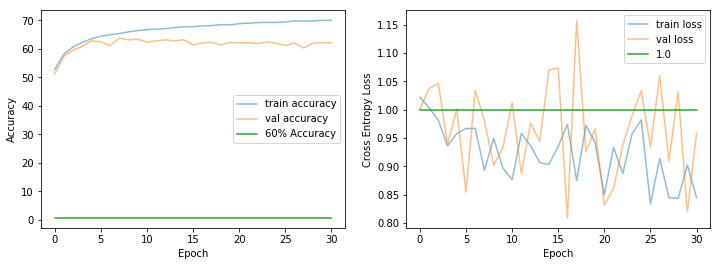

This round of parameter tuning has finished
vocab size is: 10000
Running lr with vocab_size 10000, MAX_SENTENCE_LENGTH 100, BATCH_SIZE 32, emb_dim 80, learning_rate 0.001
After training for 10 epochs, Train Acc 70.925, Val Acc 61.7, Train Loss 0.8325797319412231, Val Loss 0.7138251662254333
train: [tensor(1.0313, grad_fn=<NllLossBackward>), tensor(0.9859, grad_fn=<NllLossBackward>), tensor(0.9514, grad_fn=<NllLossBackward>), tensor(0.9516, grad_fn=<NllLossBackward>), tensor(0.9969, grad_fn=<NllLossBackward>), tensor(0.8935, grad_fn=<NllLossBackward>), tensor(0.8904, grad_fn=<NllLossBackward>), tensor(0.9597, grad_fn=<NllLossBackward>), tensor(0.8854, grad_fn=<NllLossBackward>), tensor(0.9023, grad_fn=<NllLossBackward>), tensor(0.9124, grad_fn=<NllLossBackward>), tensor(0.9039, grad_fn=<NllLossBackward>), tensor(0.9384, grad_fn=<NllLossBackward>), tensor(0.9631, grad_fn=<NllLossBackward>), tensor(0.9250, grad_fn=<NllLossBackward>), tensor(0.9211, grad_fn=<NllLossBackward>), tensor(0.853

<Figure size 432x288 with 0 Axes>

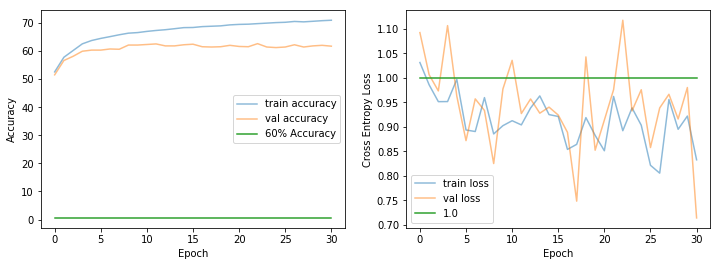

This round of parameter tuning has finished
vocab size is: 12000
Running lr with vocab_size 12000, MAX_SENTENCE_LENGTH 100, BATCH_SIZE 32, emb_dim 80, learning_rate 0.001
After training for 10 epochs, Train Acc 71.783, Val Acc 61.8, Train Loss 0.8777202367782593, Val Loss 0.9997929930686951
train: [tensor(1.0257, grad_fn=<NllLossBackward>), tensor(1.0808, grad_fn=<NllLossBackward>), tensor(0.9923, grad_fn=<NllLossBackward>), tensor(0.9821, grad_fn=<NllLossBackward>), tensor(0.9028, grad_fn=<NllLossBackward>), tensor(0.9277, grad_fn=<NllLossBackward>), tensor(0.9452, grad_fn=<NllLossBackward>), tensor(0.9190, grad_fn=<NllLossBackward>), tensor(0.8866, grad_fn=<NllLossBackward>), tensor(0.9611, grad_fn=<NllLossBackward>), tensor(0.9120, grad_fn=<NllLossBackward>), tensor(0.8975, grad_fn=<NllLossBackward>), tensor(0.8539, grad_fn=<NllLossBackward>), tensor(0.8681, grad_fn=<NllLossBackward>), tensor(0.8970, grad_fn=<NllLossBackward>), tensor(0.9395, grad_fn=<NllLossBackward>), tensor(0.886

<Figure size 432x288 with 0 Axes>

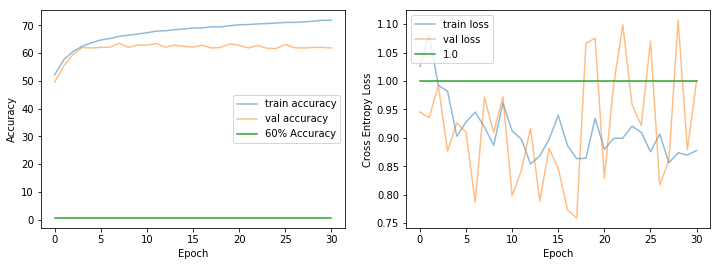

This round of parameter tuning has finished


<Figure size 432x288 with 0 Axes>

In [38]:

for vocab_size in [8000,10000,12000]:
    print('vocab size is: {}'.format(vocab_size))
    train_acc_list, val_acc_list, train_loss_list, val_loss_list = lr_pipeline(vocab_size, MAX_SENTENCE_LENGTH, BATCH_SIZE, emb_dim, learning_rate, interact='concat')
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    #plt.subplot(1,2, figsize = (12,4))
    plot_len = len(train_acc_list)

    ax1=plt.subplot(121)
    ax1.plot(range(plot_len), train_acc_list, label = 'train accuracy', alpha = 0.5)
    ax1.plot(range(plot_len), val_acc_list, label = 'val accuracy', alpha = 0.5)
    ax1.plot(range(plot_len), [0.6]*plot_len, label = '60% Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax2=plt.subplot(122)
    ax2.plot(range(len(train_loss_list)), train_loss_list, label = 'train loss', alpha = 0.5)
    ax2.plot(range(len(val_loss_list)), val_loss_list, label = 'val loss', alpha = 0.5)
    ax2.plot(range(len(val_loss_list)), [1]*len(val_loss_list), label = '1.0')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Cross Entropy Loss')
    ax2.legend()

    plt.show()
    plt.clf()
    print('This round of parameter tuning has finished')

embedding dimension is: 60
Running lr with vocab_size 10000, MAX_SENTENCE_LENGTH 100, BATCH_SIZE 32, emb_dim 60, learning_rate 0.001
After training for 10 epochs, Train Acc 70.466, Val Acc 61.5, Train Loss 0.8539179563522339, Val Loss 0.8381161689758301
model saved


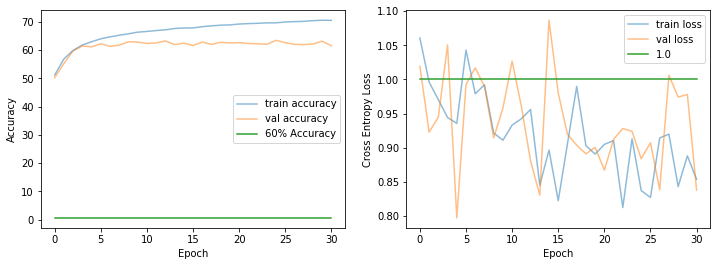

This round of parameter tuning has finished
embedding dimension is: 80
Running lr with vocab_size 10000, MAX_SENTENCE_LENGTH 100, BATCH_SIZE 32, emb_dim 80, learning_rate 0.001
After training for 10 epochs, Train Acc 71.151, Val Acc 59.7, Train Loss 0.9369485378265381, Val Loss 1.0325223207473755
model saved


<Figure size 432x288 with 0 Axes>

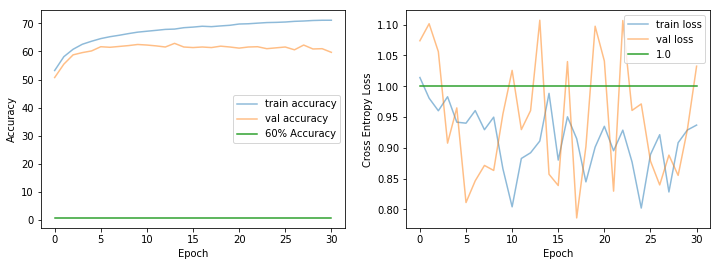

This round of parameter tuning has finished
embedding dimension is: 100
Running lr with vocab_size 10000, MAX_SENTENCE_LENGTH 100, BATCH_SIZE 32, emb_dim 100, learning_rate 0.001
After training for 10 epochs, Train Acc 71.538, Val Acc 62.6, Train Loss 0.8313165903091431, Val Loss 0.876792311668396
model saved


<Figure size 432x288 with 0 Axes>

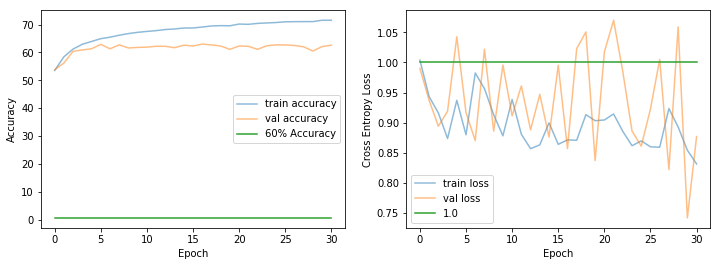

This round of parameter tuning has finished


<Figure size 432x288 with 0 Axes>

In [42]:
#group 2

vocab_size = 10000
MAX_SENTENCE_LENGTH = 100
BATCH_SIZE = 32
# emb_dim = 80
learning_rate = 0.001
interact = 'concat'

for emb_dim in [60,80,100]:
    print('embedding dimension is: {}'.format(emb_dim))
    train_acc_list, val_acc_list, train_loss_list, val_loss_list = lr_pipeline(vocab_size, MAX_SENTENCE_LENGTH, BATCH_SIZE, emb_dim, learning_rate, interact='concat')
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    #plt.subplot(1,2, figsize = (12,4))
    plot_len = len(train_acc_list)

    ax1=plt.subplot(121)
    ax1.plot(range(plot_len), train_acc_list, label = 'train accuracy', alpha = 0.5)
    ax1.plot(range(plot_len), val_acc_list, label = 'val accuracy', alpha = 0.5)
    ax1.plot(range(plot_len), [0.6]*plot_len, label = '60% Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax2=plt.subplot(122)
    ax2.plot(range(len(train_loss_list)), train_loss_list, label = 'train loss', alpha = 0.5)
    ax2.plot(range(len(val_loss_list)), val_loss_list, label = 'val loss', alpha = 0.5)
    ax2.plot(range(len(val_loss_list)), [1]*len(val_loss_list), label = '1.0')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Cross Entropy Loss')
    ax2.legend()

    plt.show()
    plt.clf()
    print('This round of parameter tuning has finished')

interaction is: concat
Running lr with vocab_size 10000, MAX_SENTENCE_LENGTH 100, BATCH_SIZE 32, emb_dim 80, learning_rate 0.001
After training for 10 epochs, Train Acc 71.126, Val Acc 60.7, Train Loss 0.8886558413505554, Val Loss 1.0376092195510864
model saved


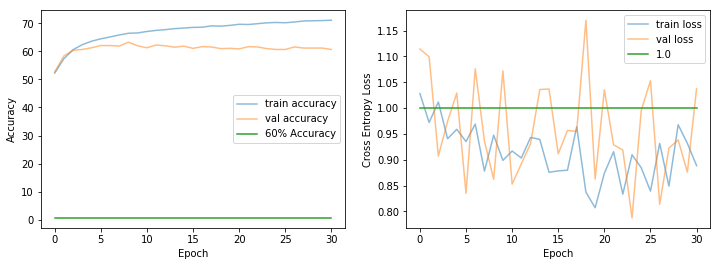

This round of parameter tuning has finished
interaction is: mul
Running lr with vocab_size 10000, MAX_SENTENCE_LENGTH 100, BATCH_SIZE 32, emb_dim 80, learning_rate 0.001
After training for 10 epochs, Train Acc 81.975, Val Acc 62.6, Train Loss 0.7820707559585571, Val Loss 0.8910773992538452
model saved


<Figure size 432x288 with 0 Axes>

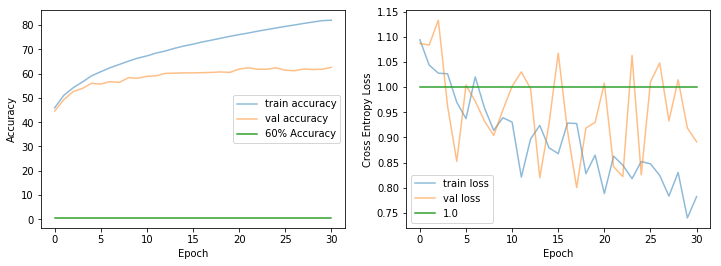

This round of parameter tuning has finished


<Figure size 432x288 with 0 Axes>

In [44]:
#group 3

vocab_size = 10000
MAX_SENTENCE_LENGTH = 100
BATCH_SIZE = 32
emb_dim = 80
learning_rate = 0.001
# interact = 'concat'

for interact in ['concat','mul']:
    print('interaction is: {}'.format(interact))
    train_acc_list, val_acc_list, train_loss_list, val_loss_list = lr_pipeline(vocab_size, MAX_SENTENCE_LENGTH, BATCH_SIZE, emb_dim, learning_rate, interact)
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    #plt.subplot(1,2, figsize = (12,4))
    plot_len = len(train_acc_list)

    ax1=plt.subplot(121)
    ax1.plot(range(plot_len), train_acc_list, label = 'train accuracy', alpha = 0.5)
    ax1.plot(range(plot_len), val_acc_list, label = 'val accuracy', alpha = 0.5)
    ax1.plot(range(plot_len), [0.6]*plot_len, label = '60% Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax2=plt.subplot(122)
    ax2.plot(range(len(train_loss_list)), train_loss_list, label = 'train loss', alpha = 0.5)
    ax2.plot(range(len(val_loss_list)), val_loss_list, label = 'val loss', alpha = 0.5)
    ax2.plot(range(len(val_loss_list)), [1]*len(val_loss_list), label = '1.0')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Cross Entropy Loss')
    ax2.legend()

    plt.show()
    plt.clf()
    print('This round of parameter tuning has finished')

In [49]:
maxvocab = [8000,10000,12000,10000,10000,10000,10000,10000,8000]
embdim = [80,80,80,60,80,100,80,80,100]
inter = ['concat','concat','concat','concat','concat','concat','concat','product','product']
trainacc = [70.078,70.925,71.783,70.466,71.151,71.538,71.126,81.975,83.023]
valacc = [62.1,61.7,61.8,61.5,59.7,62.6,60.7,62.6,64.0]
trainloss = [0.844,0.833,0.878,0.854,0.937,0.831,0.888,0.782,0.777]
valloss = [0.968,0.714,0.999,0.838,1.032,0.876,1.038,0.891,0.887]
dic = {'max_vocab':maxvocab, 'emb_dim':embdim, 'interaction':inter, 
       'training accuracy':trainacc,'val accuracy':valacc,
      'training loss':trainloss,'val loss':valloss}
pd.DataFrame(dic)

,max_vocab,emb_dim,interaction,training accuracy,val accuracy,training loss,val loss
0,8000,80,concat,70.078,62.1,0.844,0.968
1,10000,80,concat,70.925,61.7,0.833,0.714
2,12000,80,concat,71.783,61.8,0.878,0.999
3,10000,60,concat,70.466,61.5,0.854,0.838
4,10000,80,concat,71.151,59.7,0.937,1.032
5,10000,100,concat,71.538,62.6,0.831,0.876
6,10000,80,concat,71.126,60.7,0.888,1.038
7,10000,80,product,81.975,62.6,0.782,0.891
8,8000,100,product,83.023,64.0,0.777,0.887


Running lr with vocab_size 8000, MAX_SENTENCE_LENGTH 100, BATCH_SIZE 32, emb_dim 100, learning_rate 0.001
After training for 10 epochs, Train Acc 83.023, Val Acc 64.0, Train Loss 0.7777355313301086, Val Loss 0.8879222273826599
model saved


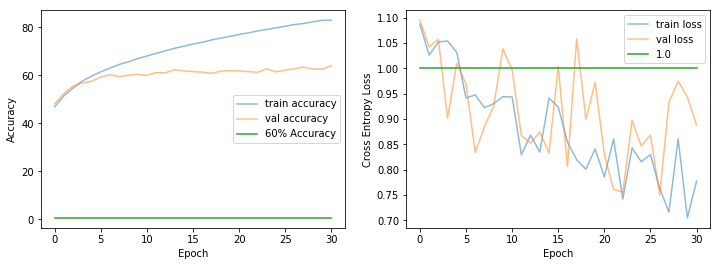

This round of parameter tuning has finished


<Figure size 432x288 with 0 Axes>

In [47]:
#best

vocab_size = 8000
MAX_SENTENCE_LENGTH = 100
BATCH_SIZE = 32
emb_dim = 100
learning_rate = 0.001
interact = 'mul'


train_acc_list, val_acc_list, train_loss_list, val_loss_list = lr_pipeline(vocab_size, MAX_SENTENCE_LENGTH, BATCH_SIZE, emb_dim, learning_rate, interact)
plt.figure(figsize=(12,4))
plt.subplot(121)
#plt.subplot(1,2, figsize = (12,4))
plot_len = len(train_acc_list)

ax1=plt.subplot(121)
ax1.plot(range(plot_len), train_acc_list, label = 'train accuracy', alpha = 0.5)
ax1.plot(range(plot_len), val_acc_list, label = 'val accuracy', alpha = 0.5)
ax1.plot(range(plot_len), [0.6]*plot_len, label = '60% Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax2=plt.subplot(122)
ax2.plot(range(len(train_loss_list)), train_loss_list, label = 'train loss', alpha = 0.5)
ax2.plot(range(len(val_loss_list)), val_loss_list, label = 'val loss', alpha = 0.5)
ax2.plot(range(len(val_loss_list)), [1]*len(val_loss_list), label = '1.0')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Cross Entropy Loss')
ax2.legend()

plt.show()
plt.clf()
print('This round of parameter tuning has finished')

In [57]:
token2id, id2token = build_vocab(all_train_tokens, vocab_size)
train_data_indices_1 = token2index_dataset(token2id,train_data_tokens_1)
train_data_indices_2 = token2index_dataset(token2id,train_data_tokens_2)
val_data_indices_1 = token2index_dataset(token2id,val_data_tokens_1)
val_data_indices_2 = token2index_dataset(token2id,val_data_tokens_2)

train_dataset = BuildDataset(train_data_indices_1, train_data_indices_2, train_target)
val_dataset = BuildDataset(val_data_indices_1, val_data_indices_2, val_target)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                       batch_size=BATCH_SIZE,
                                       collate_fn=collate_func,
                                       shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=collate_func,
                                           shuffle=True)

In [58]:
#grading session preparation

# best_lr_model = LogisticRegressionPyTorch(8002, emb_dim, 3,'mul')
# model_file = 'model/lr_9_iter_tune.ckpt'
# best_lr_model.load_state_dict(torch.load(model_file))
# val_acc = test_model(val_loader, best_lr_model)

In [59]:
val_acc

[64.0, tensor(0.7049, grad_fn=<NllLossBackward>)]

## Example Illustration

In [43]:
miss1 = []
miss2 = []
miss_label = []
miss_pred = []

hit1 = []
hit2 = []
hit_label = []

for data1, data2, len1, len2, labels in val_loader:
    data_batch1, data_batch2, len_batch1, len_batch2,label_batch = data1, data2, len1, len2, labels
    outputs = F.softmax(lg_model(data_batch1, data_batch2, len_batch1, len_batch2), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    for i, pair in enumerate(zip(label_batch, predicted)):

        label, pred = pair
        if label != pred:
            if len(miss1) < 30:
                miss1.append(' '.join([id2token[x] for x in data1[i].tolist() if x > 1]))
                miss2.append(' '.join([id2token[x] for x in data2[i].tolist() if x > 1]))
                miss_label.append(label.item())
                miss_pred.append(pred.item())

        elif label == pred:
            if len(hit1) < 30:
                hit1.append(' '.join([id2token[x] for x in data1[i].tolist() if x > 1]))
                hit2.append(' '.join([id2token[x] for x in data2[i].tolist() if x > 1]))
                hit_label.append(label.item())

print('Below shows an incorrect prediction sample')
d = {'sentence1': miss1, 'sentence2': miss2, 'label':miss_label, 'pred':miss_pred}
pd.set_option('display.max_colwidth', -1)
incorrect_pred = pd.DataFrame(data=d)

Below shows an incorrect prediction sample


In [45]:
incorrect_pred.head()

,sentence1,sentence2,label,pred
0,an asian woman in a red skirt sits near the ground with another woman standing next to her,the asian woman served rice in their restaurant,2,0
1,a child dressed in blue jeans with rolled cuffs and a pink hoodie waits outdoors at the foot of the stairs with an axe,a child waits by some stairs,1,0
2,a band of young musicians are playing an intimate concert to a small crowd in an outdoor courtyard,the band is at home sleeping,2,0
3,a teenage girl in winter clothes slides down a in a red sled,a girl is on a beach with a blue sled,2,0
4,a little blond boy throwing a soapy sponge at his moms car,a small boy throws a sponge at a car,1,0


In [46]:
d2 = {'sentence1': hit1, 'sentence2': hit2, 'label':hit_label}
pd.set_option('display.max_colwidth', -1)
correct_pred = pd.DataFrame(data=d2)

In [50]:
correct_pred[6:9]

,sentence1,sentence2,label
6,a man in a blue helmet jumping off of a hill on a dirt bike,the man is a professional athlete,0
7,a lady sitting on a bench that is against a building and under a poster of a man in a uniform waving,nobody is sitting,2
8,a woman in a blue shirt talking to a baby,a young woman talks to her baby at the park,0


In [30]:
class NN(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super().__init__()
        # pay attention to padding_idx 
        l1_dim = 100
        l2_dim = 100
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.hidden1 = nn.Linear(emb_dim*2, l1_dim)
        self.hidden2 = nn.Linear(l1_dim, l2_dim)
        self.linear = nn.Linear(l2_dim, 3)
        
    def forward(self, data1, data2, length_1, length_2):
        """
        
        @param data1: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review in sentence1 that is represented using n-gram index. Note that they are padded to have same length.
        @param data2: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review in sentence2 that is represented using n-gram index. Note that they are padded to have same length.
        @param length1: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data1.
        @param length2: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data2.
        """
        # NOTICE: here I used concatenation & take the mean (baseline), it needs future tuning
        out_1 = self.embed(data1)
        out_1 = torch.sum(out_1, dim=1)
        out_1 /= length_1.view(length_1.size()[0],1).expand_as(out_1).float()
        
        out_2 = self.embed(data2)
        out_2 = torch.sum(out_2, dim=1)
        out_2 /= length_2.view(length_2.size()[0],1).expand_as(out_2).float()

        out = torch.cat((out_1, out_2), dim=1) 
        #out = torch.sum(out, dim=1)
        #out /= (length1.view(length1.size()[0],1).expand_as(out).float() + length2.view(length2.size()[0],1).expand_as(out).float())
        
        out = F.relu(self.hidden1(out.float()))
        out = F.relu(self.hidden2(out.float()))
        # return logits
        out = self.linear(out.float())
        return out

In [32]:
emb_dim = 80
nn_model = NN(len(id2token), emb_dim)

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  

learning_rate = 0.01
optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

for x in nn_model.parameters():
    print(x.shape)

torch.Size([12002, 80])
torch.Size([100, 160])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([3, 100])
torch.Size([3])


----- Function is Logistic Regression -----
----- Embedding Dimension is 80. -----
----- The vocabulary size is 5000. -----
----- Interaction Method is concatenation. -----
Finished Epoch 0
Finished Epoch 1
Finished Epoch 2
Finished Epoch 3
Finished Epoch 4
Finished Epoch 5
Finished Epoch 6
Finished Epoch 7
Finished Epoch 8
Finished Epoch 9
The final training accuracy is :68.459
The final validation accuracy is :61.0


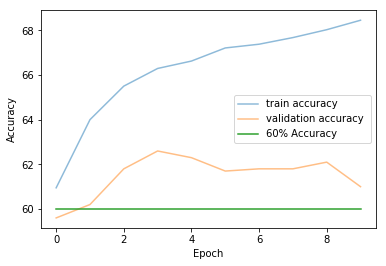

----- Function is Logistic Regression -----
----- Embedding Dimension is 80. -----
----- The vocabulary size is 5000. -----
----- Interaction Method is element wise multiplication. -----
Finished Epoch 0
Finished Epoch 1
Finished Epoch 2
Finished Epoch 3
Finished Epoch 4
Finished Epoch 5
Finished Epoch 6
Finished Epoch 7
Finished Epoch 8
Finished Epoch 9
The final training accuracy is :78.977
The final validation accuracy is :63.3


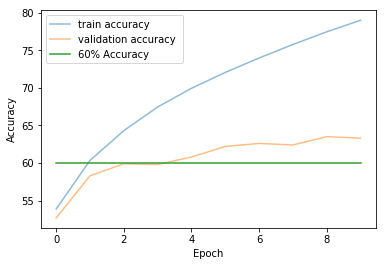

----- Function is Logistic Regression -----
----- Embedding Dimension is 120. -----
----- The vocabulary size is 5000. -----
----- Interaction Method is concatenation. -----
Finished Epoch 0
Finished Epoch 1
Finished Epoch 2
Finished Epoch 3
Finished Epoch 4
Finished Epoch 5
Finished Epoch 6
Finished Epoch 7
Finished Epoch 8
Finished Epoch 9
The final training accuracy is :68.848
The final validation accuracy is :61.9


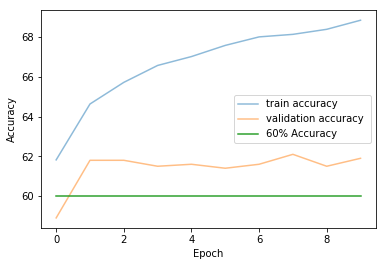

----- Function is Logistic Regression -----
----- Embedding Dimension is 120. -----
----- The vocabulary size is 5000. -----
----- Interaction Method is element wise multiplication. -----
Finished Epoch 0
Finished Epoch 1
Finished Epoch 2
Finished Epoch 3
Finished Epoch 4
Finished Epoch 5
Finished Epoch 6
Finished Epoch 7
Finished Epoch 8
Finished Epoch 9
The final training accuracy is :82.452
The final validation accuracy is :63.1


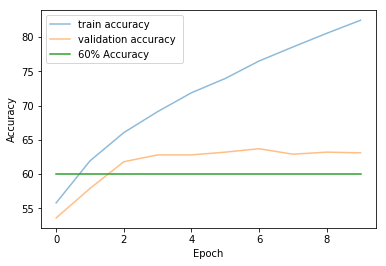

----- Function is Logistic Regression -----
----- Embedding Dimension is 80. -----
----- The vocabulary size is 10000. -----
----- Interaction Method is concatenation. -----
Finished Epoch 0
Finished Epoch 1
Finished Epoch 2
Finished Epoch 3
Finished Epoch 4
Finished Epoch 5
Finished Epoch 6
Finished Epoch 7
Finished Epoch 8
Finished Epoch 9
The final training accuracy is :70.974
The final validation accuracy is :60.7


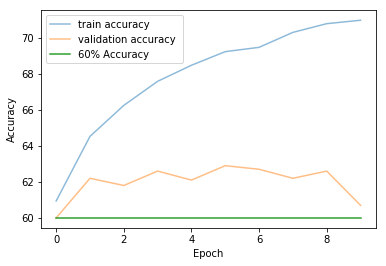

----- Function is Logistic Regression -----
----- Embedding Dimension is 80. -----
----- The vocabulary size is 10000. -----
----- Interaction Method is element wise multiplication. -----
Finished Epoch 0
Finished Epoch 1
Finished Epoch 2
Finished Epoch 3
Finished Epoch 4
Finished Epoch 5
Finished Epoch 6
Finished Epoch 7
Finished Epoch 8
Finished Epoch 9
The final training accuracy is :82.005
The final validation accuracy is :65.3


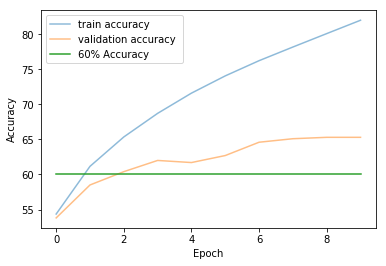

----- Function is Logistic Regression -----
----- Embedding Dimension is 120. -----
----- The vocabulary size is 10000. -----
----- Interaction Method is concatenation. -----
Finished Epoch 0
Finished Epoch 1
Finished Epoch 2
Finished Epoch 3
Finished Epoch 4
Finished Epoch 5
Finished Epoch 6
Finished Epoch 7
Finished Epoch 8
Finished Epoch 9
The final training accuracy is :71.996
The final validation accuracy is :63.7


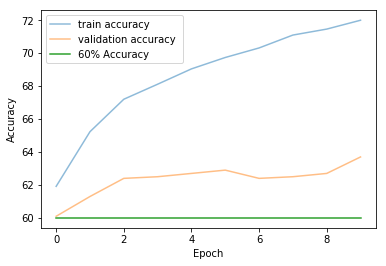

----- Function is Logistic Regression -----
----- Embedding Dimension is 120. -----
----- The vocabulary size is 10000. -----
----- Interaction Method is element wise multiplication. -----
Finished Epoch 0


In [ ]:
for max_vocab_size in [5000, 10000]:
    for emb_dim in [80, 120]:
        for interact in ['cat', 'mul']:
            tune_func_3_1(learning_rate = 0.001, func='lr', num_epochs = 10, 
                          emb_dim = emb_dim, interact = interact, 
                          max_vocab_size=max_vocab_size, MAX_SENTENCE_LENGTH=100)